In [1]:
!pwd

/home/kimbg/SPN/my_unet


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="1";

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import tensorflow as tf
import glob

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

print('tensorflow version :', tf.__version__)
print('TF GPU available test :', tf.test.is_gpu_available())

tensorflow version : 2.1.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
TF GPU available test : True


In [3]:
from bg_module import *

## 0. 각종 사용자 변수 정의

In [4]:
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

VOC_CLASSES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

## 의문 ##
# 엣지 클래스도 넣어야하는거 아닌가..???

image_dataset_path = '/data1/kimbg/voc2012/SegmentationDB/image'
gt_dataset_path = '/data1/kimbg/voc2012/SegmentationClass'

BATCH_SIZE = 8
IMG_SIZE = (256, 256, 3)

In [5]:
img_dataset_abspath = sorted(glob.glob(os.path.join(image_dataset_path, '*')))
mask_dataset_abspath = sorted(glob.glob(os.path.join(gt_dataset_path, '*')))
print(f'이미지 갯수 : {len(img_dataset_abspath)}')
print(f'마스크 갯수 : {len(mask_dataset_abspath)}')
print(list(map(os.path.basename, img_dataset_abspath))[:3])
print(list(map(os.path.basename, mask_dataset_abspath))[:3])

이미지 갯수 : 2913
마스크 갯수 : 2913
['2007_000032.jpg', '2007_000033.jpg', '2007_000039.jpg']
['2007_000032.png', '2007_000033.png', '2007_000039.png']


## 1. 이미지 확인

In [6]:
DATASET_IMG, DATASET_SEG_MASK, DATASET_MASK = dataset(image_dataset_path, gt_dataset_path, 0, 100, VOC_CLASSES, VOC_COLORMAP, IMG_SIZE)
print(DATASET_IMG.shape, DATASET_SEG_MASK.shape, DATASET_MASK.shape)

(100, 256, 256, 3) (100, 256, 256, 21) (100, 256, 256, 3)


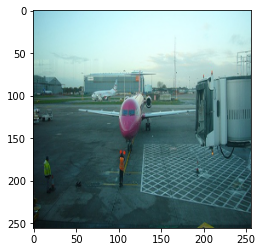

In [7]:
plt.imshow(DATASET_IMG[0])

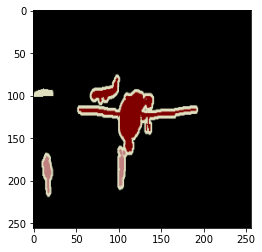

In [8]:
plt.imshow(DATASET_MASK[0])

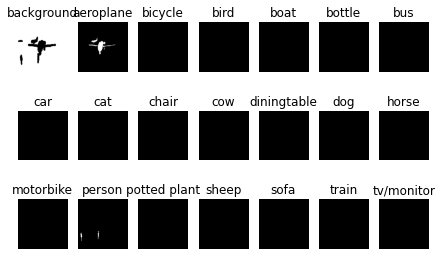

In [9]:
display_multiple_img(DATASET_SEG_MASK[0], VOC_CLASSES, 3, 7)

## 2. 모델 구성

In [10]:
def unet(target_size=(256,256,3)):

    IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS = target_size[0], target_size[1], target_size[2]

    #Build the model
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
#     s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

    #Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
    
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
    
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path 
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    
    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(21, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    
    outputs = tf.keras.layers.Conv2D(21, (1, 1), activation='softmax')(c9)
    
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

    return model
    

In [11]:
model = unet(IMG_SIZE)
# model.summary()

## 3. 모델 컴파일

In [16]:
model.compile(optimizer='adam', loss="categorical_crossentropy", 
              metrics=['accuracy','mse', tf.keras.metrics.Recall()])
# model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])

weight_path = "/home/kimbg/SPN/Colab Notebooks/MyUnet/weight/model_for_nuclei_2.h5"

callback = [
#              tf.keras.callbacks.EarlyStopping(patience=30, monitor='val_loss'),
#              tf.keras.callbacks.TensorBoard(log_dir='logs'),
             tf.keras.callbacks.ModelCheckpoint(weight_path, verbose=1, save_best_only=False)
             ]

## 4. 모델 학습

In [17]:
results = model.fit(DATASET_IMG, DATASET_SEG_MASK, 
                    validation_split=0.1, batch_size=3, epochs=500, callbacks=callback)

Train on 90 samples, validate on 10 samples
Epoch 1/500
84/90 [===========================>..] - ETA: 0s - loss: 0.9932 - accuracy: 0.7672 - mse: 0.0179 - recall: 0.6909
Epoch 00001: saving model to /home/kimbg/SPN/Colab Notebooks/MyUnet/weight/model_for_nuclei_2.h5
90/90 [==============================] - 5s 56ms/sample - loss: 1.0116 - accuracy: 0.7622 - mse: 0.0183 - recall: 0.6882 - val_loss: 1.1012 - val_accuracy: 0.7256 - val_mse: 0.0207 - val_recall: 0.6614
Epoch 2/500
84/90 [===========================>..] - ETA: 0s - loss: 0.9702 - accuracy: 0.7689 - mse: 0.0175 - recall: 0.6973
Epoch 00002: saving model to /home/kimbg/SPN/Colab Notebooks/MyUnet/weight/model_for_nuclei_2.h5
90/90 [==============================] - 1s 16ms/sample - loss: 0.9832 - accuracy: 0.7644 - mse: 0.0177 - recall: 0.6842 - val_loss: 1.1121 - val_accuracy: 0.7319 - val_mse: 0.0203 - val_recall: 0.5897
Epoch 3/500
87/90 [============================>.] - ETA: 0s - loss: 0.9417 - accuracy: 0.7792 - mse: 0.01

In [41]:
results.history.keys()

dict_keys(['loss', 'accuracy', 'mse', 'recall', 'val_loss', 'val_accuracy', 'val_mse', 'val_recall'])

# 학습 그래프 그려보기

In [25]:
hist = results

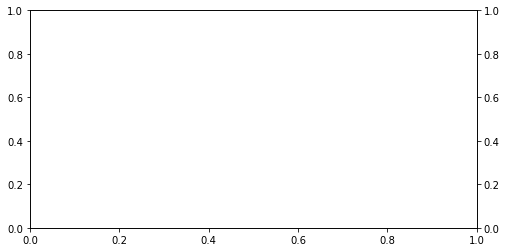

In [72]:
fig, loss_ax = plt.subplots(figsize=(8,4))
# fig, loss_ax
acc_ax = loss_ax.twinx()

# loss_ax.plot(hist.history['loss'], 'y', label='train loss')
# loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

# acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
# acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')

# loss_ax.set_xlabel('epoch')
# loss_ax.set_ylabel('loss')
# acc_ax.set_ylabel('accuray')

# loss_ax.legend(loc='upper left')
# acc_ax.legend(loc='lower left')

# plt.show()

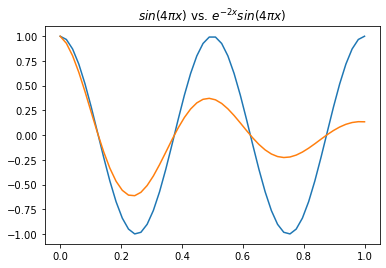

In [78]:
# example 1
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0,1,50)

y1 = np.cos(4*np.pi*x)
y2 = np.cos(4*np.pi*x)*np.exp(-2*x)
plt.title(r'$sin(4 \pi x)$ vs. $e^{-2x} sin(4 \pi x)$')
plt.plot(x,y1)
plt.plot(x,y2)

plt.show()

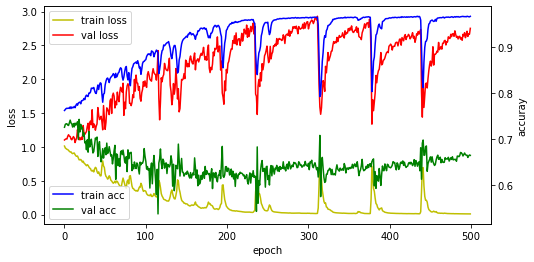

In [68]:
fig, loss_ax = plt.subplots(figsize=(8,4))
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

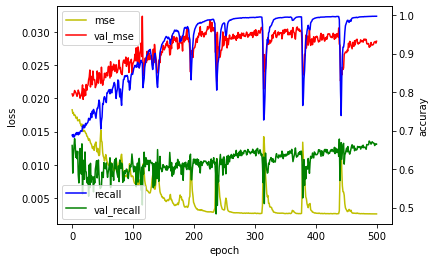

In [28]:
# dict_keys(['loss', 'accuracy', 'mse', 'recall', 'val_loss', 'val_accuracy', 'val_mse', 'val_recall'])
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['mse'], 'y', label='mse')
loss_ax.plot(hist.history['val_mse'], 'r', label='val_mse')

acc_ax.plot(hist.history['recall'], 'b', label='recall')
acc_ax.plot(hist.history['val_recall'], 'g', label='val_recall')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

## AUC ROC 커브

In [31]:
# example of a roc curve for a predictive model
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from matplotlib import pyplot

In [35]:
X.shape, y.shape

((1000, 20), (1000,))

In [37]:
# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
yhat = model.predict_proba(testX)
# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]

In [39]:
pos_probs.shape

(500,)

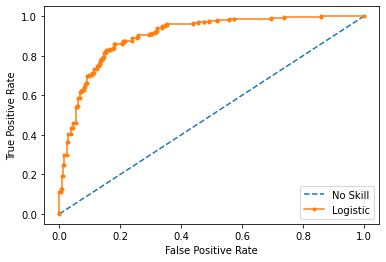

In [32]:
# plot no skill roc curve
pyplot.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
# calculate roc curve for model
fpr, tpr, _ = roc_curve(testy, pos_probs)
# plot model roc curve
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

No Skill PR AUC: 0.007
Logistic PR AUC: 0.228


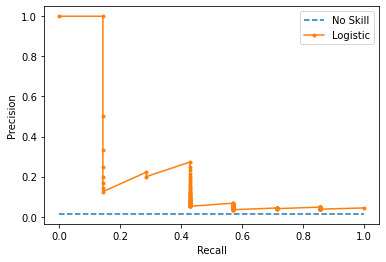

In [36]:
# pr curve and pr auc on an imbalanced dataset
from sklearn.datasets import make_classification
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from matplotlib import pyplot
 
# plot no skill and model precision-recall curves
def plot_pr_curve(test_y, model_probs):
	# calculate the no skill line as the proportion of the positive class
	no_skill = len(test_y[test_y==1]) / len(test_y)
	# plot the no skill precision-recall curve
	pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
	# plot model precision-recall curve
	precision, recall, _ = precision_recall_curve(testy, model_probs)
	pyplot.plot(recall, precision, marker='.', label='Logistic')
	# axis labels
	pyplot.xlabel('Recall')
	pyplot.ylabel('Precision')
	# show the legend
	pyplot.legend()
	# show the plot
	pyplot.show()
 
 # generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, weights=[0.99, 0.01], random_state=1)
# split into train/test sets with same class ratio
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2, stratify=y)
# no skill model, stratified random class predictions
model = DummyClassifier(strategy='stratified')
model.fit(trainX, trainy)
yhat = model.predict_proba(testX)
naive_probs = yhat[:, 1]
# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(testy, naive_probs)
auc_score = auc(recall, precision)
print('No Skill PR AUC: %.3f' % auc_score)
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
yhat = model.predict_proba(testX)
model_probs = yhat[:, 1]
# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(testy, model_probs)
auc_score = auc(recall, precision)
print('Logistic PR AUC: %.3f' % auc_score)
# plot precision-recall curves
plot_pr_curve(testy, model_probs)

## 5. 결과확인

In [40]:
pred = model.predict(DATASET_IMG[:1])
print(pred.shape)
display_multiple_img(pred[0], VOC_CLASSES, 3, 7)

ValueError: Found array with dim 4. Estimator expected <= 2.

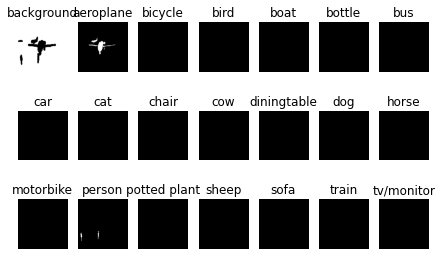

In [16]:
display_multiple_img(DATASET_SEG_MASK[0], VOC_CLASSES, 3, 7)

## 6. 모델 불러오기

In [43]:
# 모델 불러오기
from tensorflow.keras import models
model_path = '/home/kimbg/SPN/my_unet/weight/unet_voc_ms1.h5'

model = models.load_model(model_path)

In [44]:
test_img = DATASET_IMG[:1]
pred = model.predict(test_img)

In [45]:
pred.shape

(1, 256, 256, 21)

In [48]:
test_pred = pred[0,:,:,1]
print(test_pred.shape)
test_x = DATASET_SEG_MASK[0,:,:,1]
print(test_x.shape)

(256, 256)
(256, 256)


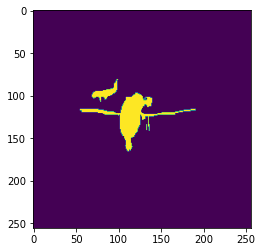

In [50]:
plt.imshow(test_x)

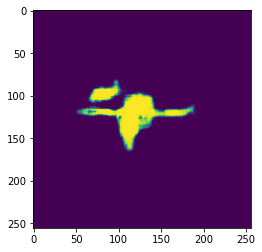

In [51]:
plt.imshow(test_pred)

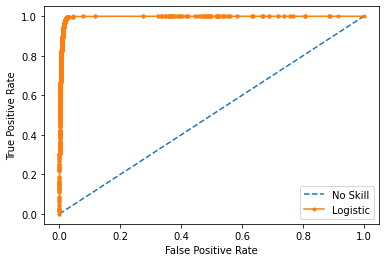

In [52]:
# plot no skill roc curve
pyplot.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
# calculate roc curve for model
fpr, tpr, _ = roc_curve(test_x.flatten(), test_pred.flatten())
# plot model roc curve
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [56]:
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test_x.flatten(), test_pred.flatten())
print('Logistic ROC AUC %.3f' % roc_auc)

Logistic ROC AUC 0.996
